# Николаева Анна

In [1]:
import json
import random
from tqdm import tqdm
import numpy as np

from matplotlib import pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

import torch

from pylab import rcParams
rcParams['figure.figsize'] = 15, 15

# Что делать?
Где есть пометка # CODE писать код

[Полезный туториал](http://jalammar.github.io/illustrated-word2vec/)

# Загружаем данные
Они уже обработанные и токенизированные. Процесс можно посмотреть в тетрадке 1.1 Processing corpus

In [2]:
with open('data/processed_corpus.json') as f:
    corpus = json.load(f)

In [3]:
len(corpus)

100000

In [4]:
for text in corpus[:5]:
    print(' '.join(text))

прекрасно подключать данный услуга просить слово сказать
находиться город обязательно обратиться отделение вернуться
ответ это обращение сообщить сотрудник банка я связаться
##число пришлый уведомление зачисление средство сотрудник направиться банкомат снятие наличный
находиться состояние подписать предложить сотрудник салон бумага покинуть салон


# CBOW

In [5]:
sample_text = corpus[1]

In [6]:
' '.join(sample_text)

'находиться город обязательно обратиться отделение вернуться'

# Реализуйте разделение предложения на примеры методом CBOW

In [7]:
def cbow_split(tokens, window, pad_token='PAD'):
    
    splits = []
    
    # CODE
    
    padding = [pad_token for i in range(window)]
    tokens = padding + tokens + padding
    for indx, word in enumerate(tokens):
        if indx < window or indx > len(tokens)-window-1:
            continue
        left_context = tokens[ indx-window : indx ]
        right_context = tokens[ indx+1 : indx+1+window ]
        splits.append((left_context,
                      word,
                      right_context))
        
    return splits

In [8]:
splits = cbow_split(sample_text, window=2)

In [9]:
for sample in splits:
    print('Левый контекст:', sample[0])
    print('Центральное слово:', sample[1])
    print('Правый контекст:', sample[2], end='\n\n')

Левый контекст: ['PAD', 'PAD']
Центральное слово: находиться
Правый контекст: ['город', 'обязательно']

Левый контекст: ['PAD', 'находиться']
Центральное слово: город
Правый контекст: ['обязательно', 'обратиться']

Левый контекст: ['находиться', 'город']
Центральное слово: обязательно
Правый контекст: ['обратиться', 'отделение']

Левый контекст: ['город', 'обязательно']
Центральное слово: обратиться
Правый контекст: ['отделение', 'вернуться']

Левый контекст: ['обязательно', 'обратиться']
Центральное слово: отделение
Правый контекст: ['вернуться', 'PAD']

Левый контекст: ['обратиться', 'отделение']
Центральное слово: вернуться
Правый контекст: ['PAD', 'PAD']



In [10]:
splits

[(['PAD', 'PAD'], 'находиться', ['город', 'обязательно']),
 (['PAD', 'находиться'], 'город', ['обязательно', 'обратиться']),
 (['находиться', 'город'], 'обязательно', ['обратиться', 'отделение']),
 (['город', 'обязательно'], 'обратиться', ['отделение', 'вернуться']),
 (['обязательно', 'обратиться'], 'отделение', ['вернуться', 'PAD']),
 (['обратиться', 'отделение'], 'вернуться', ['PAD', 'PAD'])]

# Expected

```python
[(['PAD', 'PAD'], 'вопрос', ['почему', 'например']),
 (['PAD', 'вопрос'], 'почему', ['например', 'китайский']),
 (['вопрос', 'почему'], 'например', ['китайский', 'японский']),
 (['почему', 'например'], 'китайский', ['японский', 'UNK']),
 (['например', 'китайский'], 'японский', ['UNK', 'PAD']),
 (['китайский', 'японский'], 'UNK', ['PAD', 'PAD'])]
```

In [11]:
cbow_split(sample_text, window=3)

[(['PAD', 'PAD', 'PAD'], 'находиться', ['город', 'обязательно', 'обратиться']),
 (['PAD', 'PAD', 'находиться'],
  'город',
  ['обязательно', 'обратиться', 'отделение']),
 (['PAD', 'находиться', 'город'],
  'обязательно',
  ['обратиться', 'отделение', 'вернуться']),
 (['находиться', 'город', 'обязательно'],
  'обратиться',
  ['отделение', 'вернуться', 'PAD']),
 (['город', 'обязательно', 'обратиться'],
  'отделение',
  ['вернуться', 'PAD', 'PAD']),
 (['обязательно', 'обратиться', 'отделение'],
  'вернуться',
  ['PAD', 'PAD', 'PAD'])]

# Expected

```python
[(['PAD', 'PAD', 'PAD'], 'вопрос', ['почему', 'например', 'китайский']),
 (['PAD', 'PAD', 'вопрос'], 'почему', ['например', 'китайский', 'японский']),
 (['PAD', 'вопрос', 'почему'], 'например', ['китайский', 'японский', 'UNK']),
 (['вопрос', 'почему', 'например'], 'китайский', ['японский', 'UNK', 'PAD']),
 (['почему', 'например', 'китайский'], 'японский', ['UNK', 'PAD', 'PAD']),
 (['например', 'китайский', 'японский'], 'UNK', ['PAD', 'PAD', 'PAD'])]
```

# Skipgram

In [12]:
' '.join(sample_text)

'находиться город обязательно обратиться отделение вернуться'

# Реализуйте разделение предложения на примеры методом Skipgram

In [13]:
def skipgram_split(tokens, window):
    
    splits = []
    
    # CODE
    
    for i, central_word in enumerate(tokens):
        context = tokens[i - window:i] + tokens[i + 1:i + 1 + window]
        for token in context:
            splits.append((token, central_word))
        
    return splits

In [14]:
splits = skipgram_split(sample_text, window=2)

In [15]:
# 'находиться город обязательно обратиться отделение вернуться'


for sample in splits:
    print('Контекст:', sample[0])
    print('Центральное слово:', sample[1], end='\n\n')

Контекст: город
Центральное слово: находиться

Контекст: обязательно
Центральное слово: находиться

Контекст: обязательно
Центральное слово: город

Контекст: обратиться
Центральное слово: город

Контекст: находиться
Центральное слово: обязательно

Контекст: город
Центральное слово: обязательно

Контекст: обратиться
Центральное слово: обязательно

Контекст: отделение
Центральное слово: обязательно

Контекст: город
Центральное слово: обратиться

Контекст: обязательно
Центральное слово: обратиться

Контекст: отделение
Центральное слово: обратиться

Контекст: вернуться
Центральное слово: обратиться

Контекст: обязательно
Центральное слово: отделение

Контекст: обратиться
Центральное слово: отделение

Контекст: вернуться
Центральное слово: отделение

Контекст: обратиться
Центральное слово: вернуться

Контекст: отделение
Центральное слово: вернуться



In [16]:
# 'находиться город обязательно обратиться отделение вернуться'

skipgram_split(sample_text, window=2)

[('город', 'находиться'),
 ('обязательно', 'находиться'),
 ('обязательно', 'город'),
 ('обратиться', 'город'),
 ('находиться', 'обязательно'),
 ('город', 'обязательно'),
 ('обратиться', 'обязательно'),
 ('отделение', 'обязательно'),
 ('город', 'обратиться'),
 ('обязательно', 'обратиться'),
 ('отделение', 'обратиться'),
 ('вернуться', 'обратиться'),
 ('обязательно', 'отделение'),
 ('обратиться', 'отделение'),
 ('вернуться', 'отделение'),
 ('обратиться', 'вернуться'),
 ('отделение', 'вернуться')]

# Expected

```python
[('почему', 'вопрос'),
 ('например', 'вопрос'),
 ('вопрос', 'почему'),
 ('например', 'почему'),
 ('китайский', 'почему'),
 ('вопрос', 'например'),
 ('почему', 'например'),
 ('китайский', 'например'),
 ('японский', 'например'),
 ('почему', 'китайский'),
 ('например', 'китайский'),
 ('японский', 'китайский'),
 ('UNK', 'китайский'),
 ('например', 'японский'),
 ('китайский', 'японский'),
 ('UNK', 'японский'),
 ('китайский', 'UNK'),
 ('японский', 'UNK')]
```

In [17]:
skipgram_split(sample_text, window=3)

[('город', 'находиться'),
 ('обязательно', 'находиться'),
 ('обратиться', 'находиться'),
 ('обязательно', 'город'),
 ('обратиться', 'город'),
 ('отделение', 'город'),
 ('обратиться', 'обязательно'),
 ('отделение', 'обязательно'),
 ('вернуться', 'обязательно'),
 ('находиться', 'обратиться'),
 ('город', 'обратиться'),
 ('обязательно', 'обратиться'),
 ('отделение', 'обратиться'),
 ('вернуться', 'обратиться'),
 ('город', 'отделение'),
 ('обязательно', 'отделение'),
 ('обратиться', 'отделение'),
 ('вернуться', 'отделение'),
 ('обязательно', 'вернуться'),
 ('обратиться', 'вернуться'),
 ('отделение', 'вернуться')]

# Expected

```python
[('почему', 'вопрос'),
 ('например', 'вопрос'),
 ('китайский', 'вопрос'),
 ('вопрос', 'почему'),
 ('например', 'почему'),
 ('китайский', 'почему'),
 ('японский', 'почему'),
 ('вопрос', 'например'),
 ('почему', 'например'),
 ('китайский', 'например'),
 ('японский', 'например'),
 ('UNK', 'например'),
 ('вопрос', 'китайский'),
 ('почему', 'китайский'),
 ('например', 'китайский'),
 ('японский', 'китайский'),
 ('UNK', 'китайский'),
 ('почему', 'японский'),
 ('например', 'японский'),
 ('китайский', 'японский'),
 ('UNK', 'японский'),
 ('например', 'UNK'),
 ('китайский', 'UNK'),
 ('японский', 'UNK')]
```

In [19]:
word2index = {}

for text in corpus:
    for token in text:
        if token not in word2index:
            word2index[token] = len(word2index)

In [20]:
len(word2index)

13093

In [21]:
word2index['UNK']

114

In [22]:
[word2index[tok] if tok in word2index else word2index['UNK'] for tok in 'мама мыть рама'.split()]

[762, 2370, 114]

# Torch Dataset
В торче есть очень удобная читалка данных

In [23]:
from torch.utils.data import Dataset, DataLoader

In [24]:
# игрушечный датасет
# 121535 примера, 4 фичи, 3 класса
some_data_x = np.random.rand(121535, 4)
some_data_y = np.random.randint(3, size=(121535,))

In [25]:
# соверешенно игрушечный, просто цифры
some_data_x[:10]

array([[0.37845793, 0.50541573, 0.44616673, 0.85551861],
       [0.14112603, 0.47863324, 0.62618673, 0.77532575],
       [0.56870857, 0.79760615, 0.42355776, 0.13935764],
       [0.23386451, 0.29657513, 0.46543181, 0.2951885 ],
       [0.98998147, 0.15395462, 0.37801956, 0.29360006],
       [0.06269091, 0.08285928, 0.69917684, 0.65087432],
       [0.60438823, 0.03390359, 0.84109538, 0.28520837],
       [0.81865458, 0.43954226, 0.31793868, 0.04343867],
       [0.66972754, 0.83272348, 0.00248143, 0.22046506],
       [0.6119843 , 0.00832763, 0.64793098, 0.9840461 ]])

In [26]:
some_data_y

array([1, 1, 2, ..., 1, 1, 0])

In [27]:
class ToyDataset(Dataset):
    
    def __init__(self, data_x, data_y):
        
        super().__init__()
        
        self.data_x = data_x
        self.data_y = data_y
        
    def __len__(self):
        
        # Нужно обязательно определить эту функцию
        # Должна возвращать размер датасета
        
        return len(self.data_x)
    
    def __getitem__(self, idx):
        
        # Еще нужно определить этот метод
        # То есть как мы будем доставать наши данные по индексу
        
        return self.data_x[idx], self.data_y[idx]

In [28]:
some_dataset = ToyDataset(some_data_x, some_data_y)

In [29]:
some_dataset[5], some_dataset[467]

((array([0.06269091, 0.08285928, 0.69917684, 0.65087432]), 1),
 (array([0.06879659, 0.20539507, 0.98933612, 0.66368584]), 1))

In [30]:
some_loader = DataLoader(some_dataset, batch_size=16, shuffle=True)

In [31]:
for x, y in some_loader:
    break
    
len(x), x

(16, tensor([[0.7422, 0.5426, 0.6591, 0.3861],
         [0.4014, 0.6134, 0.8648, 0.1174],
         [0.9113, 0.6158, 0.2357, 0.7590],
         [0.3596, 0.7064, 0.3132, 0.1490],
         [0.7358, 0.4384, 0.6979, 0.3583],
         [0.9755, 0.1079, 0.1322, 0.2627],
         [0.5113, 0.9031, 0.1460, 0.8269],
         [0.3225, 0.9216, 0.9685, 0.6016],
         [0.2027, 0.2169, 0.9026, 0.7390],
         [0.9954, 0.3339, 0.5905, 0.2066],
         [0.4975, 0.8926, 0.6773, 0.1682],
         [0.6259, 0.6513, 0.1442, 0.4967],
         [0.3069, 0.2005, 0.6778, 0.6877],
         [0.5363, 0.3601, 0.5982, 0.5712],
         [0.1751, 0.0618, 0.2861, 0.2335],
         [0.8252, 0.7113, 0.1973, 0.7844]], dtype=torch.float64))

In [32]:
for x, y in some_loader:
    pass

len(x)

15

In [33]:
# почему 13?
# потому что количество наших данных нацело не делится на 16
# и поэтому последний батч меньше 16-ти
len(some_dataset) % 16

15

# А зачем?

In [34]:
class ToyDataset(Dataset):
    
    def __init__(self, data_x, data_y):
        
        super().__init__()
        
        self.data_x = data_x
        self.data_y = data_y
        
    def __len__(self):
        
        # Нужно обязательно определить эту функцию
        # Должна возвращать размер датасета
        
        return len(self.data_x)
    
    @staticmethod
    def add_pow_features(x, n=2):
        
        return np.concatenate([x, x ** n]) 
    
    @staticmethod
    def add_log_features(x):
        
        return np.concatenate([x, np.log(x)]) 
    
    def __getitem__(self, idx):
        
        # Еще нужно определить этот метод
        # То есть как мы будем доставать наши данные по индексу
        
        x = self.data_x[idx]
        
        # внутри датасета мы можем делать все что угодно с нашими данными
        # например выше определим функции, которые добавляют степенные фичи
        x = self.add_pow_features(x, n=2)
        x = self.add_pow_features(x, n=3)
        # и еще возьмем логарифмические фичи
        x = self.add_log_features(x)
        
        y = self.data_y[idx]
        
        return x, y

In [35]:
toy_dataset = ToyDataset(some_data_x, some_data_y)

In [36]:
toy_loader = DataLoader(dataset=toy_dataset, batch_size=128)

In [37]:
for x, y in toy_loader:
    break

In [38]:
x.shape

torch.Size([128, 32])

In [39]:
# заметим, что мы сразу получаем торчовый формат данных
x

tensor([[  0.3785,   0.5054,   0.4462,  ...,  -4.0942,  -4.8424,  -0.9363],
        [  0.1411,   0.4786,   0.6262,  ...,  -4.4209,  -2.8086,  -1.5268],
        [  0.5687,   0.7976,   0.4236,  ...,  -1.3568,  -5.1544, -11.8243],
        ...,
        [  0.1684,   0.1630,   0.6501,  ..., -10.8826,  -2.5839,  -2.8311],
        [  0.2434,   0.3738,   0.6718,  ...,  -5.9035,  -2.3870,  -1.4318],
        [  0.4479,   0.6398,   0.0704,  ...,  -2.6796, -15.9208,  -4.9256]],
       dtype=torch.float64)

In [40]:
y

tensor([1, 1, 2, 1, 0, 1, 0, 2, 1, 1, 0, 1, 1, 0, 1, 2, 2, 1, 1, 0, 2, 0, 1, 1,
        2, 1, 2, 0, 1, 0, 2, 2, 1, 0, 2, 2, 1, 2, 2, 0, 2, 2, 1, 0, 0, 1, 2, 2,
        2, 2, 1, 1, 1, 1, 1, 0, 0, 2, 1, 1, 1, 2, 0, 1, 0, 1, 2, 1, 2, 0, 0, 0,
        1, 2, 2, 0, 1, 1, 2, 1, 0, 2, 0, 1, 1, 1, 1, 2, 1, 2, 0, 1, 1, 0, 2, 1,
        2, 0, 0, 2, 1, 2, 2, 1, 1, 2, 1, 2, 0, 2, 0, 1, 2, 0, 0, 1, 2, 0, 2, 1,
        0, 2, 1, 2, 1, 1, 2, 0])

# Если вы ничего здесь не понимаете, то вернитесь в конец первой домашки, там все объясняется

In [41]:
model = torch.nn.Sequential(torch.nn.Linear(32, 16),
                            torch.nn.ReLU(),
                            torch.nn.Linear(16, 8),
                            torch.nn.ReLU(),
                            torch.nn.Linear(8, 3))

criterion = torch.nn.CrossEntropyLoss()

In [42]:
with torch.no_grad():

    prediction = model(x.float())

    loss = criterion(prediction, y)
    
loss.item()

1.2069809436798096

# Боевые датасеты

In [43]:
class CBOWDataset(Dataset):

    def __init__(self,
                 corpus,
                 word2index,
                 window=2,
                 unk_token='UNK',
                 pad_token='PAD',
                 collect_verbose=True):

        self.corpus = corpus
        self.word2index = word2index
        self.index2word = {value: key for key, value in self.word2index.items()}
        self.window = window

        self.unk_token = unk_token
        self.unk_index = self.word2index[self.unk_token]

        self.pad_token = pad_token
        self.pad_index = len(self.word2index)

        self.collect_verbose = collect_verbose

        self.data = []

        self.collect_data()

    def __len__(self):

        return len(self.data)

    def _split_function(self, tokenized_text):

        splits = []

        for n in range(len(tokenized_text)):
            left_context = tokenized_text[np.maximum(n - self.window, 0):n]
            left_context = ([self.pad_index] * (self.window - len(left_context))) + left_context

            central_word = tokenized_text[n]

            right_context = tokenized_text[n + 1:n + self.window + 1]
            right_context = right_context + ([self.pad_index] * (self.window - len(right_context)))

            splits.append((left_context + right_context, central_word))

        return splits

    def indexing(self, tokenized_text):

        return [self.word2index[token] if token in self.word2index else self.unk_index for token in tokenized_text]

    def collect_data(self):

        corpus = tqdm(self.corpus, disable=not self.collect_verbose)

        for tokenized_text in corpus:
            indexed_text = self.indexing(tokenized_text)
            cbow_examples = self._split_function(indexed_text)

            self.data.extend(cbow_examples)

    def __getitem__(self, idx):

        context, central_word = self.data[idx]

        context = torch.Tensor(context).long()

        return context, central_word

# Мы будем учить модель Skipgram
Реализуйте читалку данных

In [44]:
class SkipgramDataset(Dataset):

    def __init__(self,
                 corpus,
                 word2index,
                 window=2,
                 unk_token='UNK',
                 collect_verbose=True):

        self.corpus = corpus
        self.word2index = word2index
        self.index2word = {value: key for key, value in self.word2index.items()}
        self.window = window

        self.unk_token = unk_token
        self.unk_index = self.word2index[self.unk_token]

        self.collect_verbose = collect_verbose

        self.data = []

        self.collect_data()

    def __len__(self):

        return len(self.data)

    def _split_function(self, tokenized_text):
        
        # CODE
        
        splits = []
        
        for i, central_word in enumerate(tokenized_text):
            context = tokenized_text[i - self.window:i] + tokenized_text[i + 1:i + 1 + self.window]
            for token in context:
                splits.append((token, central_word))

        return splits

    def indexing(self, tokenized_text):

        return [self.word2index[token] if token in self.word2index else self.unk_index for token in tokenized_text]

    def collect_data(self):

        corpus = tqdm(self.corpus, disable=not self.collect_verbose)

        for tokenized_text in corpus:
            indexed_text = self.indexing(tokenized_text)
            skipgram_examples = self._split_function(indexed_text)
            self.data.extend(skipgram_examples)
                    
    def __getitem__(self, idx):
        
        # CODE
        context, central_word = self.data[idx]
        
        return context, central_word

In [45]:
# from word2vec_utils import SkipgramDataset

In [46]:
dataset = SkipgramDataset(corpus, word2index)

100%|██████████| 100000/100000 [00:02<00:00, 49907.72it/s]


In [47]:
BATCH_SIZE = 512

In [48]:
dataset_loader = DataLoader(dataset, shuffle=True, batch_size=BATCH_SIZE)

In [51]:
dataset.data[:10]

[(1, 0),
 (2, 0),
 (2, 1),
 (3, 1),
 (0, 2),
 (1, 2),
 (3, 2),
 (4, 2),
 (1, 3),
 (2, 3)]

In [52]:
for x, y in dataset_loader:
    break

In [53]:
x[:5]

tensor([3891, 1390,   49,  173,   42])

In [54]:
y[:5]

tensor([  311,   976,   178,  4021, 11705])

In [55]:
x.shape, y.shape

(torch.Size([512]), torch.Size([512]))

In [56]:
class CBOW(torch.nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, pad_index):
        
        super().__init__()
        
        if pad_index > 0:
            vocab_size += 1
        
        self.in_embedding = torch.nn.Embedding(num_embeddings=vocab_size, 
                                               embedding_dim=embedding_dim,
                                               padding_idx=pad_index)
        
        self.out_embedding = torch.nn.Linear(in_features=embedding_dim,
                                             out_features=vocab_size, bias=False)
        
    def forward(self, x):
        
        x = self.in_embedding(x).sum(dim=-2)
        x = self.out_embedding(x)
        
        return x

# Мы будем учить модель Skipgram
Реализуйте ее

In [142]:
# CODE
class SkipGram(torch.nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        
        super(SkipGram, self).__init__()
        
        self.in_embedding = torch.nn.Embedding(num_embeddings=vocab_size, 
                                               embedding_dim=embedding_dim)
        
        self.out_embedding = torch.nn.Linear(in_features=embedding_dim,
                                             out_features=vocab_size, bias=False)
                
    def forward(self, x):
        
        x = self.in_embedding(x)
        x = self.out_embedding(x)
#        out = torch.nn.functional.log_softmax(x)
        
        return x
    

#    def forward(self, inputs):
#        embeds = self.embeddings(inputs).view((1, -1))
#        out = self.linear(embeds)
#        log_probs = F.log_softmax(out)
#        return log_probs

In [143]:
# размерность эмбеддинга
# маленькая, чтобы мы могли недолго поучить ворд2век и увидеть результаты
EMBEDDING_DIM = 20

In [144]:
model = SkipGram(vocab_size=len(word2index), embedding_dim=EMBEDDING_DIM)

In [145]:
with torch.no_grad():
    pred = model(x)

pred.shape

torch.Size([512, 13093])

In [149]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

# aka loss function
criterion = torch.nn.CrossEntropyLoss()

# Допишите обучалку

In [150]:
epochs = 3

losses = []

for n_epoch in range(epochs):

    try:

        progress_bar = tqdm(total=len(dataset_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))

        for x, y in dataset_loader:

            # CODE
            
            optimizer.zero_grad()
            pred = model.forward(x)            
            loss = criterion(pred, y.long()) 
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            
            
            progress_bar.set_postfix(loss=np.mean(losses[-100:]))
            progress_bar.update(x.shape[0])

        progress_bar.close()

    except KeyboardInterrupt:

        progress_bar.close()
        break

Epoch 3: 100%|██████████| 2884549/2884549 [10:11<00:00, 2458.56it/s, loss=6.89]


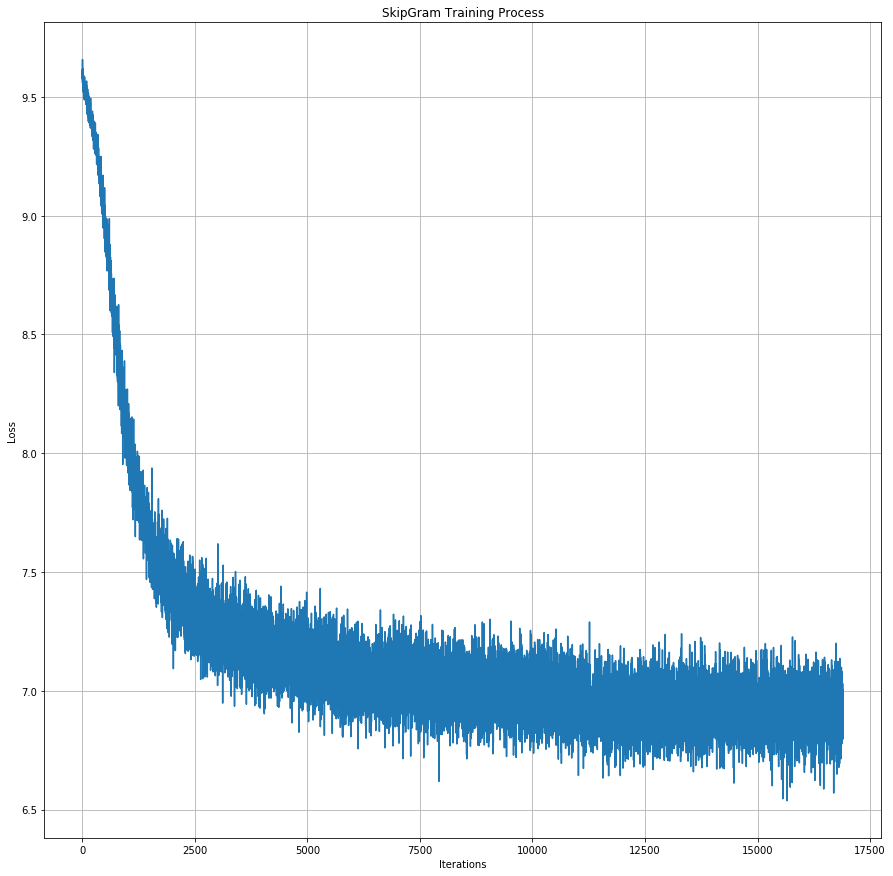

In [154]:
plt.title('SkipGram Training Process')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid()
plt.plot(losses)
plt.fig_size = [15, 15]

# lr = 0.001

In [155]:
# проверка, что хоть что-то выучилось
assert np.mean(losses[-1000:]) < 7.0

In [197]:
np.mean(losses[-1000:])

6.906914813995361

In [156]:
embedding_matrix = model.in_embedding.weight.detach()

In [157]:
def cos_sim(embedding_matrix, token2id, word1, word2):
    
    i1 = token2id[word1]
    i2 = token2id[word2]
    
    v1, v2 = embedding_matrix[i1], embedding_matrix[i2]
    
    v1_n = v1.div(v1.norm(keepdim=True))
    v2_n = v2.div(v2.norm(keepdim=True))
    
    similarity = torch.dot(v1_n, v2_n).item()
    
    return similarity

# Косинусная близость
От 0 до 1, где 0 - вектора абсолютно разные, где 1 - идентичные.

In [198]:
cos_sim(embedding_matrix, word2index, 'банкомат', 'терминал')

0.5591917037963867

In [199]:
cos_sim(embedding_matrix, word2index, 'день', 'месяц')

0.5967458486557007

In [200]:
cos_sim(embedding_matrix, word2index, 'минута', 'месяц')

0.5957382917404175

In [201]:
cos_sim(embedding_matrix, word2index, 'сотрудник', 'сотрудница')

0.5019572973251343

In [202]:
cos_sim(embedding_matrix, word2index, 'вклад', 'перевод')

0.4940342307090759

In [203]:
random_word = random.choice(list(word2index.keys()))
sim = cos_sim(embedding_matrix, word2index, 'москва', random_word)
'Косинусная близость слова "москва" к случайному выбраному слову "{}" равна {:.3f}'.format(random_word, sim)

'Косинусная близость слова "москва" к случайному выбраному слову "двойка" равна 0.027'

In [190]:
freq = {}

for text in corpus:
    for token in text:
        if token in freq:
            freq[token] += 1
        else:
            freq[token] = 1

In [191]:
sorted_freq = [(k, freq[k]) for k in sorted(freq, key=freq.get, reverse=True)]
top_sorted_freq = sorted_freq[0:200]

In [192]:
tsne = TSNE(n_components=2, init='pca', random_state=42, verbose=2)
reduced = tsne.fit_transform(embedding_matrix)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 13093 samples in 0.045s...
[t-SNE] Computed neighbors for 13093 samples in 10.293s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13093
[t-SNE] Computed conditional probabilities for sample 2000 / 13093
[t-SNE] Computed conditional probabilities for sample 3000 / 13093
[t-SNE] Computed conditional probabilities for sample 4000 / 13093
[t-SNE] Computed conditional probabilities for sample 5000 / 13093
[t-SNE] Computed conditional probabilities for sample 6000 / 13093
[t-SNE] Computed conditional probabilities for sample 7000 / 13093
[t-SNE] Computed conditional probabilities for sample 8000 / 13093
[t-SNE] Computed conditional probabilities for sample 9000 / 13093
[t-SNE] Computed conditional probabilities for sample 10000 / 13093
[t-SNE] Computed conditional probabilities for sample 11000 / 13093
[t-SNE] Computed conditional probabilities for sample 12000 / 13093
[t-SNE] Computed conditional probabilities for sa

In [194]:
top_words = [a for a,_ in top_sorted_freq]

In [195]:
inds = [word2index[word] for word in top_words]
x_coords = [coords[0] for coords in reduced[inds]]
y_coords = [coords[1] for coords in reduced[inds]]

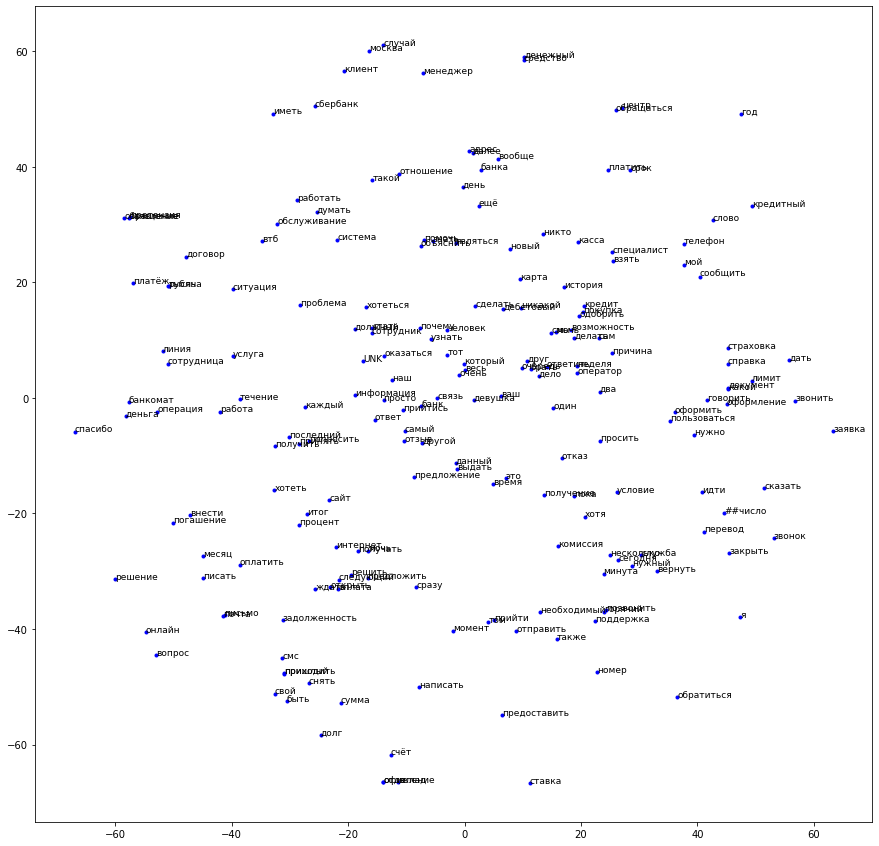

In [196]:
for (x, y, word) in zip(x_coords, y_coords, top_words):
    plt.scatter(x, y, marker='.', color='blue')
    plt.text(x+0.01, y+0.01, word, fontsize=9)
plt.show()